# Introduction
* Hello, our names are Cristian, and Geary
* This is a project detailing the process undertaken to predict the cases of `Language` (Code)

### Project Objectives
- Document code, process, findings, and key takeaways.
- Make your process repeateable and your report (notebook) easy to read and follow.
- Ask exploratory questions of your data. Answer questions through charts and statistical tests.
- Construct a model to predict customer churn using classification techniques.
- Refine your work into a Report.
- Be prepared to answer panel questions.

### Business Goals
- Predict a language based on the contents of the Readme
- Construct a ML classification model that accurately predicts language.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

### Executive Summary
* Relied on unique common words and counts for bulk of feature differientation to predict `Language`
* Feature sets informed by the combination of Feature Engineering and Word Counts
* Model gain on predictive performance vs. baseline prediction was improvement on test set (from ~20% -> ~40%)

In [1]:
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import unicodedata
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import env
from wrangle import * 
from explore_modeling import *

# Acquire Phase

> if looking to refresh data source (GITHUB REPOSITORIES) change to true
 - Goes to the most forked pages and finds links to the repositories
 - Uses the url and passes to the api to pull down the info using API key and User-Name
    - (will need your own env file with both)
 - Creates dataframe from url, language primarily written in (code), and the README
> Otherwise, pulls from csv that has info cached

In [2]:
refresh_datasource=False
# pretty much as the variables describe
if refresh_datasource:
    list_repo = get_repo_names()
    df= to_update_or_not_to_udpate(True,list_repo)
else:
    #pulls from csv
    df= to_update_or_not_to_udpate(False)

# Prepare phase
> starting the prepare on the dataframe
 - drops na if applicable (on language and readme contents)
 - cleans using regex and language type (encode and decode)
 - tokenizes
 - removes stop words
 - stems
 - lems
> feature creation/clean/tidy
 - sorts articles by language and finds "set" of words for each
 - compares sets and returns only unique for each language
 - compares each article to unique common word and returns count as feature

In [3]:
lang, df, most_common_list, count_feature_list, low_lang_count = prep_work(df)
df.shape, df.info()

dropped na
cleaned
stemmed
lemmed
<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 529
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   repo                          487 non-null    object
 1   language                      487 non-null    object
 2   readme_contents               487 non-null    object
 3   clean                         487 non-null    object
 4   stemmed                       487 non-null    object
 5   lemmatized                    487 non-null    object
 6   clean_lang                    487 non-null    object
 7   count_set_lem                 487 non-null    int64 
 8   count_most_common_JavaScript  487 non-null    object
 9   count_most_common_Python      487 non-null    object
 10  count_most_common_Java        487 non-null    object
 11  count_most_common_HTML        487 non-null    object
 12  count_most_common_Other       487 non-null  

((487, 14), None)

<function matplotlib.pyplot.show(close=None, block=None)>

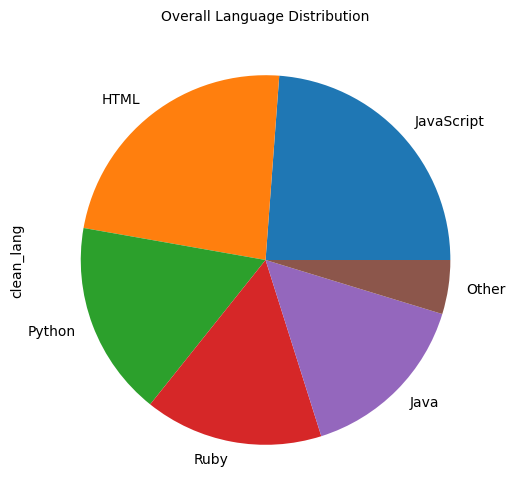

In [4]:
plt.figure(figsize= (12,6))
df["clean_lang"].value_counts(normalize=True).plot.pie()
#plt.legend(loc='upper right',fontsize=6)#upper right#upper left#lower left#lower right#right#center left#center right#lower center#upper center#center
plt.title("Overall Language Distribution",fontsize=10)
plt.show

# End of Prepare and Acquire:
- Cleaned and tidied our Readmes through tokenization and lemmetization
- Counted a match on unique wordcount for each language for most common
- Sorted Languages and returned word counts
- Distributions of primary languages are relatively similar


# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

Let's investigate if our Languages contain inequal distributions of unique words (to itself) enough "oomph" to be considered significant
##  **Hypothesis 1 - Are the mean count_values of Unique Words in Each Language equal to the Population in relation to Non-Repeating Words for the ReadMes**

> $H_0$: The mean values of `Non-Repeating Words(Readme)_langauge` will not be signifcantly different from `Non-Repeating Words(Readme)_population`.    
> $H_a$: Rejection of Null ~~The mean values of `Non-Repeating Words(Readme)_langauge` will not be signifcantly different from `Non-Repeating Words(Readme)_population`.~~  
> alpha = .05  
> - Conclusion: There is enough evidence to reject our null hypothesis for SOME cases

count_set_lem <-target | clean_lang <-population name | JavaScript <-sample name
We fail to reject the null hypothesis ( JavaScript as a sample has equal mean values to clean_lang as a population regarding Non-Repeating Words ) t=-0.07802, p=0.93795
----------
count_set_lem <-target | clean_lang <-population name | Python <-sample name
We reject the null Hypothesis ( P̶y̶t̶h̶o̶n̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶e̶a̶n̶_̶l̶a̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶N̶o̶n̶-̶R̶e̶p̶e̶a̶t̶i̶n̶g̶ ̶W̶o̶r̶d̶s̶ ) t=2.51196, p=0.01397
----------
count_set_lem <-target | clean_lang <-population name | Java <-sample name
We fail to reject the null hypothesis ( Java as a sample has equal mean values to clean_lang as a population regarding Non-Repeating Words ) t=0.49655, p=0.62098
----------
count_set_lem <-target | clean_lang <-population name | HTML <-sample name
We reject the null Hypothesis ( H̶T̶M̶L̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶

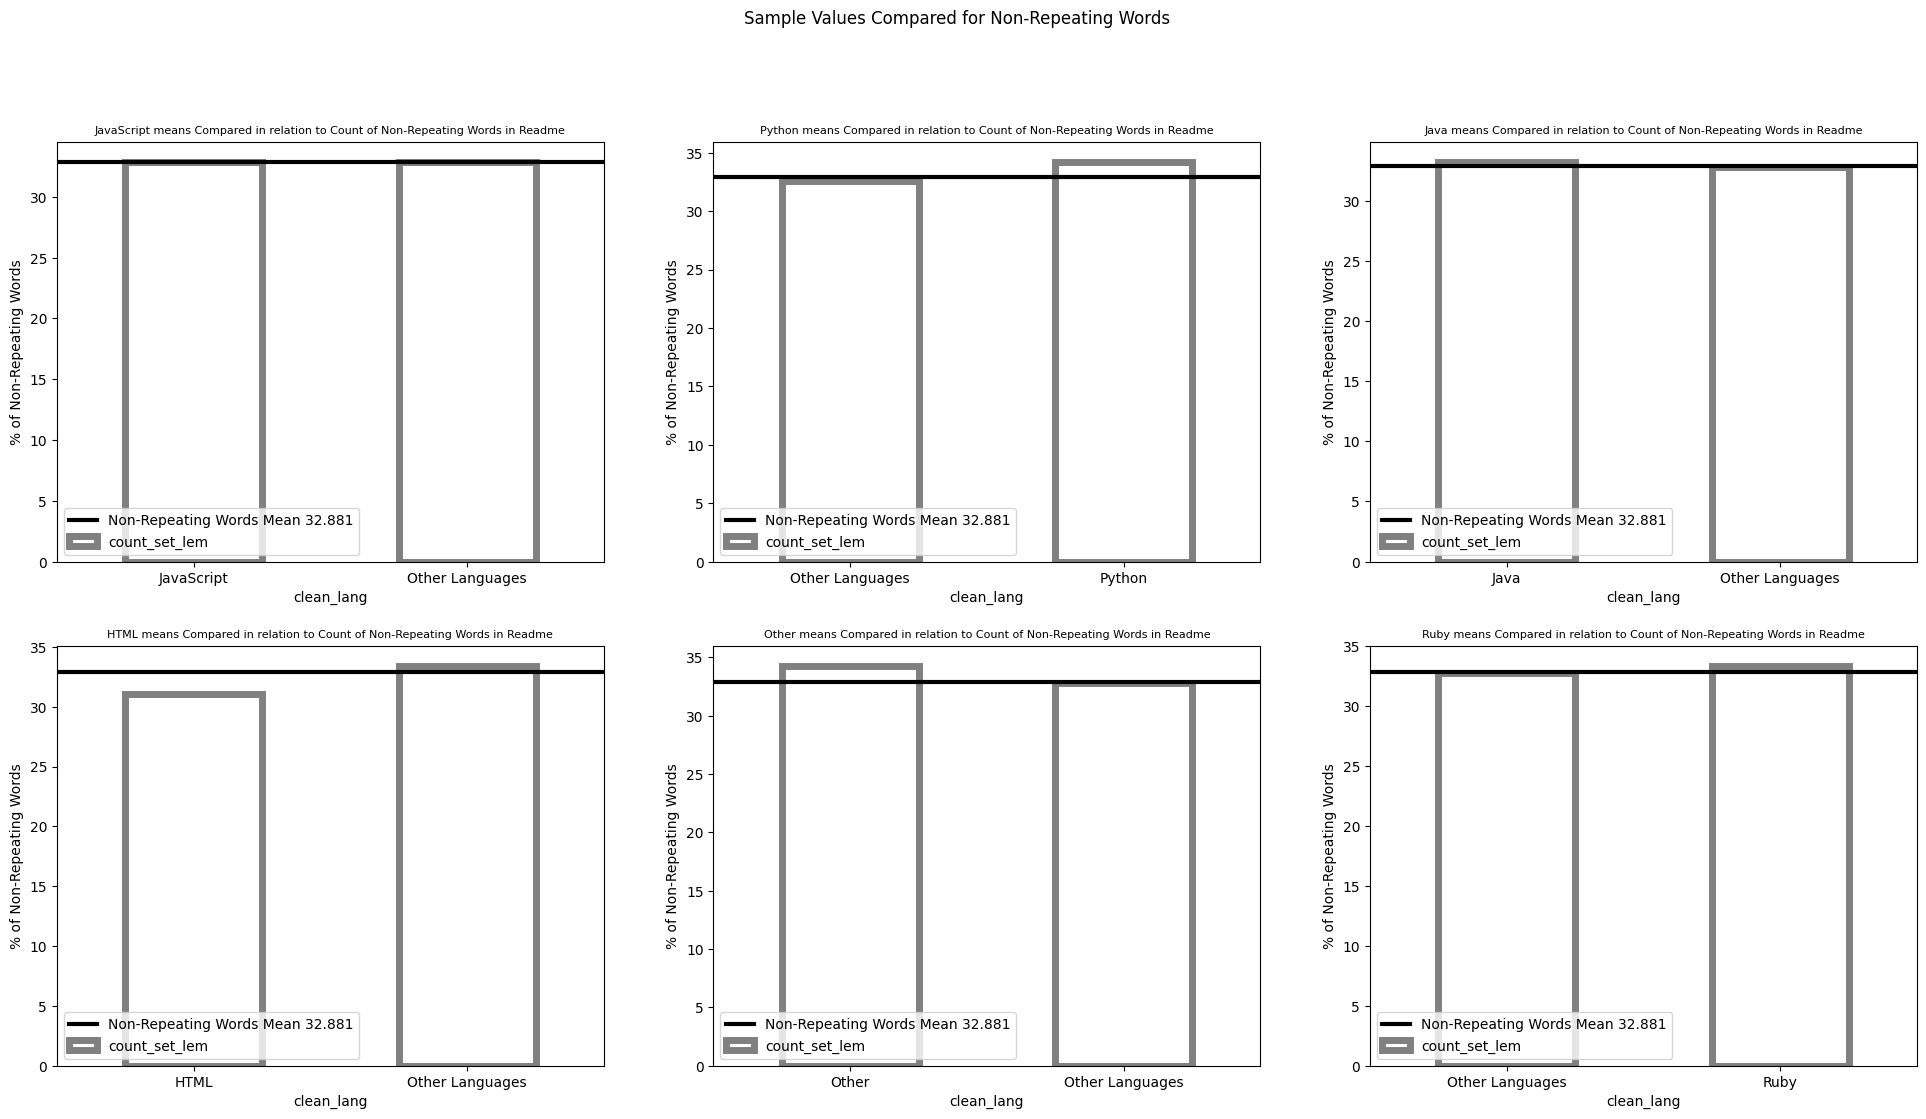

The ones that are similar in value -> ('JavaScript', 'Java', 'Other', 'Ruby') 
The ones not similar in value -> ('Python', 'HTML')


In [5]:
explore_ttest_lang_setcount(df)

### Takeaways:
- The languages of Python, Other, and HTML share similar values in their word count set "uniqueness"
    - This is not a good feature to use to determine Language for these values
- The languages of Java, TypeScript, and JavaScript are unique in their word count set "uniqueness"
    - This is a good feature to use to determine Language for these values  
    
*`This feature is not the answer by itself and will need addtional features to help determine Language, however it is not completly worthless and we will be considering it's use in modeling.`*

# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>


hypothesis 2
does the ttl amount of words vary by language - yes
does 

hypothesis 3
does the length of the repo readme (word amount) vary by language


# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

##  **Hypothesis 4 - Is the distribution of Count of Common words unique to a language a cood indicator of that language (Porportionality)**

> $H_0$: The distribution of `Non-Repeating Words(Readme)_langauge` will be consistent between languages.    
> $H_a$: Rejection of Null ~~The distribution of `Non-Repeating Words(Readme)_langauge` will be consistent between languages..~~  
> alpha = .05  
> - Conclusion: There is enough evidence to reject our null hypothesis for ALL cases

---
chi^2 = 34613.4291, p = 0.00000, degf = 25
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  L̶a̶n̶g̶u̶a̶g̶e̶s̶ ̶i̶s̶ ̶n̶o̶t̶ ̶d̶i̶f̶f̶e̶r̶e̶n̶t̶ ̶i̶n̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶ ̶o̶f̶ ̶C̶o̶m̶m̶o̶n̶ ̶U̶n̶i̶q̶u̶e̶ ̶C̶o̶u̶n̶t̶ )


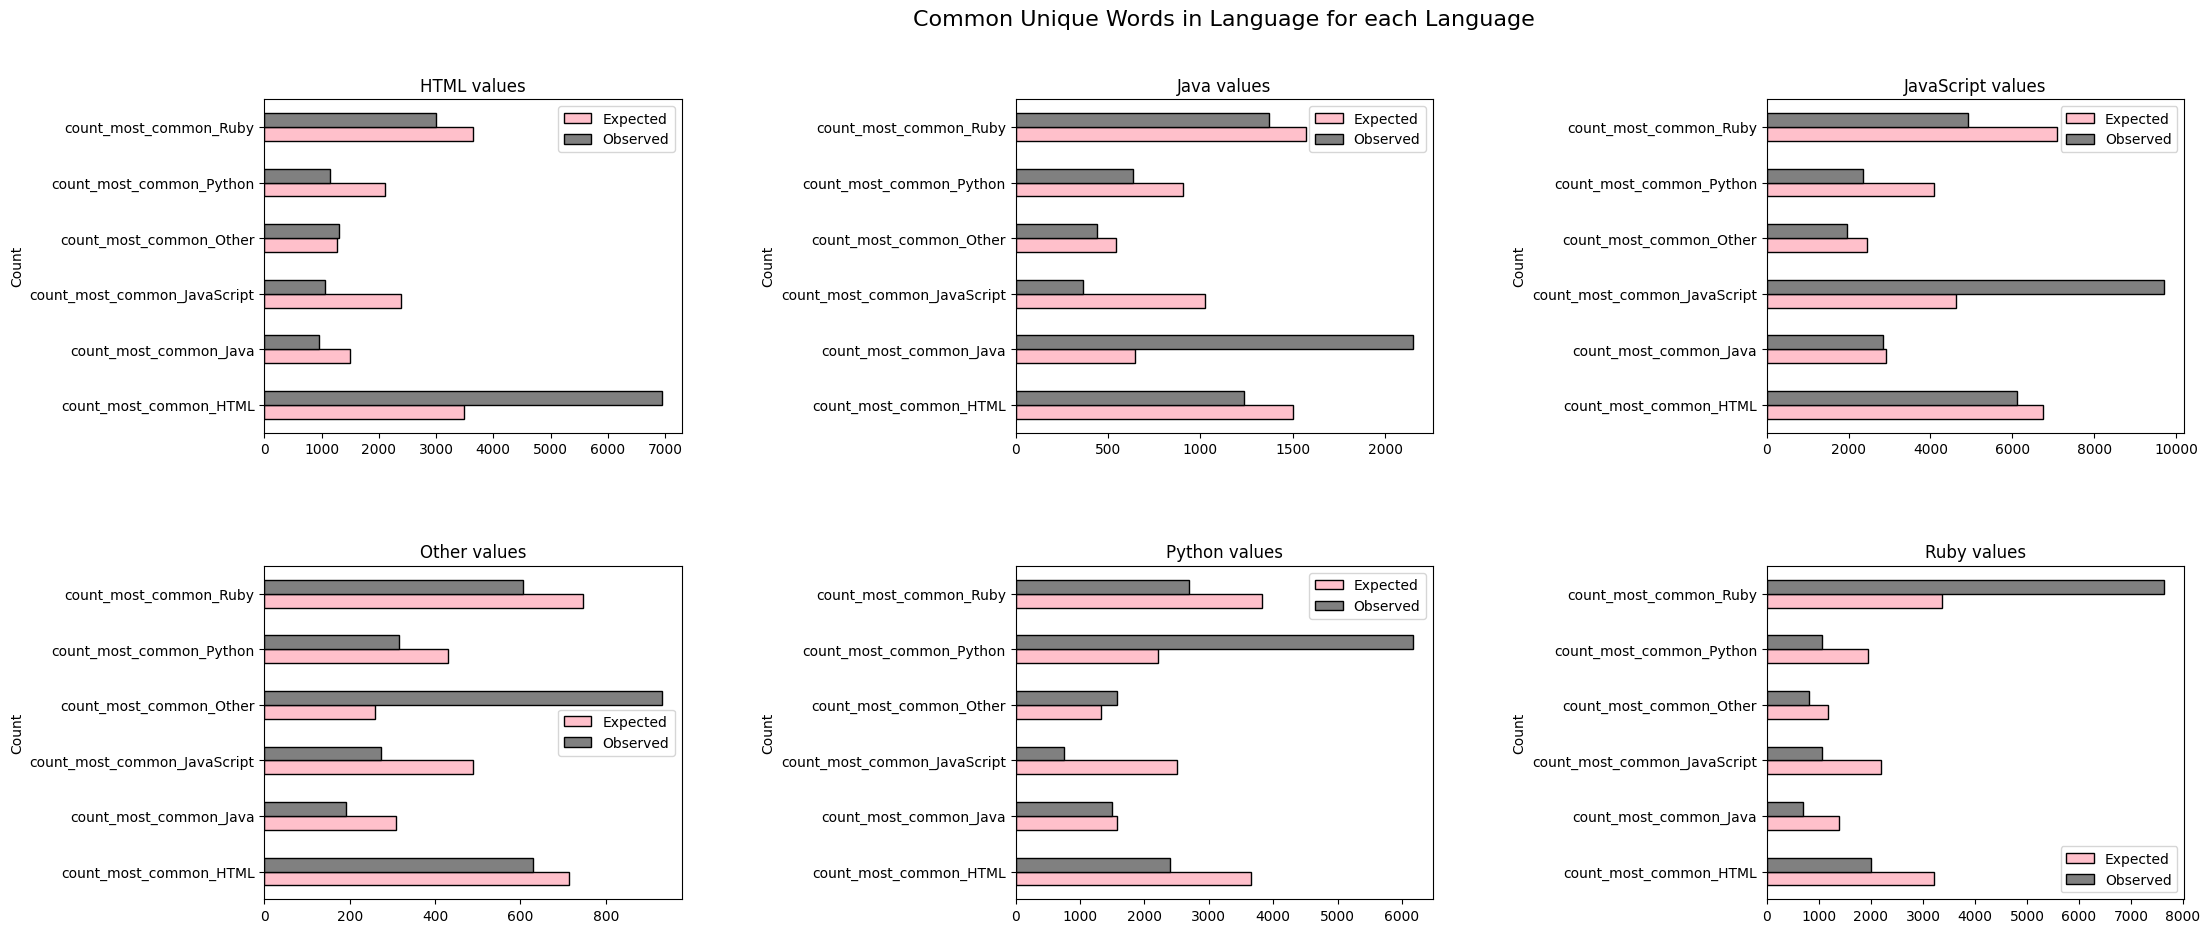

In [6]:
chi2_for_lang(df)

### Takeaways:
- Using Count Unique Words for each language holds different porportions from what would be a normal distribution, and as such is a good indicator for use in modeling to predict our class.
- In all cases the percentage difference between expected and observed is pretty good and indicates it will be applicable across a large portion of the dataset
  
  *`This will be a helpful indicator for modeling and will be recommended for it's use`*

## Explore Takeaways:
>Count of common words for each language will be a strong indicator for classifying Language

# Modeling
## remember to pull in other fresh dataframes

In [8]:
X_train,X_validate,X_test,y_train,y_validate,y_test,train_scaled,validate_scaled,test_scaled = prep_for_modeling(df,lang)

dropped na
cleaned
stemmed
lemmed
(21, 14) (22, 14)


Using RFE to reduce the amount of features (due to using large amout of word count)

In [9]:
y_train_encoded = y_train.copy()
for num,stri in enumerate(y_train_encoded.unique()):
    print(num,stri)
    y_train_encoded.replace({stri:num},inplace=True)
rec_list = rfe(X_train,y_train_encoded,5)
best_list = rec_list[rec_list["Rank"]>5]["Var"].tolist()

0 JavaScript
1 Python
2 Java
3 HTML
4 Other
5 Ruby
                              rfe_ranking
count_most_common_JavaScript            1
ruby                                    1
javascript                              1
create                                  1
method                                  1


## Baseline Values

In [10]:
round(df.clean_lang.value_counts(normalize=True)*100,1).apply(str)+"%"

JavaScript    23.8%
HTML          23.4%
Python        17.0%
Ruby          15.6%
Java          15.4%
Other          4.7%
Name: clean_lang, dtype: object

In [11]:
leafs = init_modeling(X_train[best_list],X_validate[best_list],y_train,y_validate)

              precision    recall  f1-score   support

        HTML       0.74      0.71      0.73       114
        Java       0.44      0.77      0.56        75
  JavaScript       0.72      0.68      0.70       116
       Other       1.00      0.09      0.16        23
      Python       0.90      0.69      0.78        83
        Ruby       0.67      0.64      0.66        76

    accuracy                           0.67       487
   macro avg       0.75      0.60      0.60       487
weighted avg       0.72      0.67      0.67       487
 	 Decision Tree classification report on train set
              precision    recall  f1-score   support

        HTML       0.20      0.33      0.25         3
        Java       0.43      1.00      0.60         3
  JavaScript       0.33      0.25      0.29         4
       Other       0.00      0.00      0.00         2
      Python       0.67      0.50      0.57         4
        Ruby       1.00      0.60      0.75         5

    accuracy              

# Takeaways:
- Best accuracy found with Decision Tree (48%), will be using that for moving forward to testing
- Knearest, RandFor, and LogReg where not as accuracte and may be with fine tuning

In [12]:
clf = DecisionTreeClassifier(max_depth= int(leafs), random_state= 1, criterion="gini")
clf = clf.fit(X_train[best_list],y_train)
y_pred_test_dt = clf.predict(X_test[best_list])

print(classification_report(y_test, y_pred_test_dt), "\t Decision Tree classification report on test set")

              precision    recall  f1-score   support

        HTML       0.25      0.50      0.33         4
        Java       0.29      1.00      0.44         2
  JavaScript       1.00      0.40      0.57         5
       Other       0.00      0.00      0.00         1
      Python       0.33      0.20      0.25         5
        Ruby       1.00      0.40      0.57         5

    accuracy                           0.41        22
   macro avg       0.48      0.42      0.36        22
weighted avg       0.60      0.41      0.42        22
 	 Decision Tree classification report on test set


### Test model Takeaway
Improves on baseline accuracy by 21%. Would recommend this model over baseline! (but maybe not so much for HTML and Java)

# Conclusion

## Summary of Key Findings
* A large portion of ReadMe content was unusual words and mispellings
* Common Unique Word Count creation was able to show difference in `Language` prediction
* Feature sets informed by wordcounts performed best on model through validation phase
    * Best model utilized combination of word count per language and overall counts per word
* Model gain on predictive performance vs. baseline prediction was decent on test set
    * Baseline accuracy: ~20%
    * Test model accuracy: ~40% (Higher is better)  
    
## Suggestions and Next Steps
* Dive deeper into what makes each language's ReadMe unique
* Take a look at adding more features into the model to create a more robust predictor
    - Boolean values on significance (common unique word count passes threshould)
* Investigate features highlighted by RFE and see how they perform
* Possible look at reducing variation within features by analyzing significance
    - Identify features were `Language` variation was driven by primarly outliers (looking at you HTML)
* May consider creating different or tailored specific models
* Take different approach to combining the data
    - Rely more on the raw features rather than feature engineering